In [428]:
import requests, json
import pandas as pd
import numpy as np
%matplotlib inline
SESSION = requests.Session()
f = open("bs_node_ip.txt","r")
RPC_HOST = f.readline()
RPC_HOST = str.replace(RPC_HOST,'\n','')
RPC_PORT = '8545'
RPC_URL = 'http://'+RPC_HOST+':'+RPC_PORT
pd.set_option('max_colwidth', 70)

## Basic JSON downloading

In [333]:
def getJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    response = json.loads(json_data)
    return response

In [334]:
def getRawJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    return json_data

In [335]:
# test if the getJSON function supports GET requests
# getJSON('https://api.etherscan.io/api?module=account&action=balance&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&tag=latest&apikey=YourApiKeyToken')

In [336]:
# test if the getJSON function supports POST requests
# getJSON(RPC_URL,'{"jsonrpc":"2.0","method":"eth_syncing","params":[],"id":1}')

## Consensys EthJsonRpc Package

I wasn't able to quickly make the package work on Python 3

In [337]:
# from ethjsonrpc import EthJsonRpc
# c = EthJsonRpc('35.196.250.157', 8545)
# print(c.net_version())
# print(c.web3_clientVersion())
# print(c.eth_gasPrice())

So I began copying their functions. Most of them still need testing. Ideally we should fork and make our own package compatible with Python 3

In [338]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def hex_to_dec(x):
    '''
    Convert hex to decimal
    '''
    return int(x, 16)

In [339]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def clean_hex(d):
    '''
    Convert decimal to hex and remove the "L" suffix that is appended to large
    numbers
    '''
    return hex(d).rstrip('L')

In [340]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def validate_block(block):
#     doesn't work on Python 3
#     if isinstance(block, basestring):
#         if block not in BLOCK_TAGS:
#             raise ValueError('invalid block tag')
    if isinstance(block, int):
        block = hex(block)
    return block

In [341]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def wei_to_ether(wei):
    '''
    Convert wei to ether
    '''
    return 1.0 * wei / 10**18

In [342]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def ether_to_wei(ether):
    '''
    Convert ether to wei
    '''
    return ether * 10**18

In [343]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/exceptions.py
class EthJsonRpcError(Exception):
    pass
class ConnectionError(EthJsonRpcError):
    pass
class BadStatusCodeError(EthJsonRpcError):
    pass
class BadJsonError(EthJsonRpcError):
    pass
class BadResponseError(EthJsonRpcError):
    pass

In [344]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
BLOCK_TAG_EARLIEST = 'earliest'
BLOCK_TAG_LATEST   = 'latest'
BLOCK_TAG_PENDING  = 'pending'
BLOCK_TAGS = (
    BLOCK_TAG_EARLIEST,
    BLOCK_TAG_LATEST,
    BLOCK_TAG_PENDING,
)

In [345]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def _call(method, params=None, _id=1):
    params = params or []
    data = {
        'jsonrpc': '2.0',
        'method':  method,
        'params':  params,
        'id':      _id,
    }
    scheme = 'http'
#     if tls:
#         scheme += 's'
    url = '{}://{}:{}'.format(scheme, RPC_HOST, RPC_PORT)
    headers = {'Content-Type': 'application/json'}
    try:
        r = SESSION.post(url, headers=headers, data=json.dumps(data))
    except RequestsConnectionError:
        raise ConnectionError
    if r.status_code / 100 != 2:
        raise BadStatusCodeError(r.status_code)
    try:
        response = r.json()
    except ValueError:
        raise BadJsonError(r.text)
    try:
        return response['result']
    except KeyError:
        raise BadResponseError(response)

In [346]:
################################################################################
# high-level methods
################################################################################

In [347]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def transfer(from_, to, amount):
    '''
    Send wei from one address to another
    '''
    return eth_sendTransaction(from_address=from_, to_address=to, value=amount)

In [348]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def create_contract(from_, code, gas, sig=None, args=None):
    '''
    Create a contract on the blockchain from compiled EVM code. Returns the
    transaction hash.
    '''
    from_ = from_ or eth_coinbase()
    if sig is not None and args is not None:
         types = sig[sig.find('(') + 1: sig.find(')')].split(',')
         encoded_params = encode_abi(types, args)
         code += encoded_params.encode('hex')
    return eth_sendTransaction(from_address=from_, gas=gas, data=code)

In [349]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def get_contract_address(tx):
    '''
    Get the address for a contract from the transaction that created it
    '''
    receipt = eth_getTransactionReceipt(tx)
    return receipt['contractAddress']

In [350]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call(address, sig, args, result_types):
    '''
    Call a contract function on the RPC server, without sending a
    transaction (useful for reading data)
    '''
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    response = eth_call(to_address=address, data=data_hex)
    return decode_abi(result_types, response[2:].decode('hex'))

In [351]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def call_with_transaction(from_, address, sig, args, gas=None, gas_price=None, value=None):
    '''
    Call a contract function by sending a transaction (useful for storing
    data)
    '''
    gas = gas or DEFAULT_GAS_PER_TX
    gas_price = gas_price or DEFAULT_GAS_PRICE
    data = _encode_function(sig, args)
    data_hex = data.encode('hex')
    return eth_sendTransaction(from_address=from_, to_address=address, data=data_hex, gas=gas,
                                    gas_price=gas_price, value=value)

In [352]:
################################################################################
# JSON-RPC methods
################################################################################

In [353]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_clientVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_clientversion
    NEEDS TESTING
    '''
    return _call('web3_clientVersion')

In [354]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_sha3(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_sha3
    NEEDS TESTING
    '''
    data = str(data).encode('hex')
    return _call('web3_sha3', [data])

In [355]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_version
    NEEDS TESTING
    '''
    return _call('net_version')

In [356]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_listening():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_listening
    NEEDS TESTING
    '''
    return _call('net_listening')

In [357]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def net_peerCount():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#net_peercount
    NEEDS TESTING
    '''
    return hex_to_dec(_call('net_peerCount'))

In [358]:
def eth_protocolVersion():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_protocolversion
    NEEDS TESTING
    '''
    return _call('eth_protocolVersion')

In [359]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_syncing():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_syncing
    TESTED - MARKUS 2018-02-07
    '''
    return _call('eth_syncing')

In [360]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_coinbase():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_coinbase
    NEEDS TESTING
    '''
    return _call('eth_coinbase')

In [361]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_mining():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_mining
    NEEDS TESTING
    '''
    return _call('eth_mining')

In [362]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_hashrate():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_hashrate
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_hashrate'))

In [363]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_gasPrice():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gasprice
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_gasPrice'))

In [364]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_accounts():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_accounts
    NEEDS TESTING
    '''
    return _call('eth_accounts')

In [365]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_blockNumber():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_blocknumber
    TESTED - MARKUS 2018-02-07
    '''
    return hex_to_dec(_call('eth_blockNumber'))

In [366]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBalance(address=None, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getbalance
    TESTED - MARKUS 2018-02-07
    '''
    address = address or eth_coinbase()
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBalance', [address, block]))

In [367]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getStorageAt(address=None, position=0, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getstorageat
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getStorageAt', [address, hex(position), block])

In [368]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionCount(address, block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactioncount
    TESTED - MARKUS 2018-02-07
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getTransactionCount', [address, block]))

In [369]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbyhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getBlockTransactionCountByHash', [block_hash]))

In [370]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockTransactionCountByNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblocktransactioncountbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getBlockTransactionCountByNumber', [block]))

In [371]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockHash(block_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblockhash
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_getUncleCountByBlockHash', [block_hash]))

In [372]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleCountByBlockNumber(block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclecountbyblocknumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return hex_to_dec(_call('eth_getUncleCountByBlockNumber', [block]))

In [373]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCode(address, default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcode
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    return _call('eth_getCode', [address, default_block])

In [374]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sign(address, data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sign
    NEEDS TESTING
    '''
    return _call('eth_sign', [address, data])

In [375]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendTransaction(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                        nonce=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendtransaction
    NEEDS TESTING
    '''
    params = {}
    params['from'] = from_address or eth_coinbase()
    if to_address is not None:
        params['to'] = to_address
    if gas is not None:
        params['gas'] = hex(gas)
    if gas_price is not None:
        params['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        params['value'] = clean_hex(value)
    if data is not None:
        params['data'] = data
    if nonce is not None:
        params['nonce'] = hex(nonce)
    return _call('eth_sendTransaction', [params])

In [376]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_sendRawTransaction(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_sendrawtransaction
    NEEDS TESTING
    '''
    return _call('eth_sendRawTransaction', [data])

In [377]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_call(to_address, from_address=None, gas=None, gas_price=None, value=None, data=None,
             default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_call
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return _call('eth_call', [obj, default_block])

In [378]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_estimateGas(to_address=None, from_address=None, gas=None, gas_price=None, value=None, data=None,
                    default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_estimategas
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    if to_address is not None:
        obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return hex_to_dec(_call('eth_estimateGas', [obj, default_block]))

In [379]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByHash(block_hash, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbyhash
    NEEDS TESTING
    '''
    return _call('eth_getBlockByHash', [block_hash, tx_objects])

In [380]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByNumber(block=BLOCK_TAG_LATEST, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getBlockByNumber', [block, tx_objects])

In [381]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByHash(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyhash
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByHash', [tx_hash])

In [382]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByBlockHashAndIndex', [block_hash, hex(index)])

In [383]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getTransactionByBlockNumberAndIndex', [block, hex(index)])

In [384]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionReceipt(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionreceipt
    NEEDS TESTING
    '''
    return _call('eth_getTransactionReceipt', [tx_hash])

In [385]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockHashAndIndex(block_hash, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblockhashandindex
    NEEDS TESTING
    '''
    return _call('eth_getUncleByBlockHashAndIndex', [block_hash, hex(index)])

In [386]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getUncleByBlockNumberAndIndex(block=BLOCK_TAG_LATEST, index=0):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getunclebyblocknumberandindex
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getUncleByBlockNumberAndIndex', [block, hex(index)])

In [387]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getCompilers():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getcompilers
    NEEDS TESTING
    '''
    return _call('eth_getCompilers')

In [388]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSolidity(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilesolidity
    NEEDS TESTING
    '''
    return _call('eth_compileSolidity', [code])

In [389]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileLLL(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compilelll
    N/A
    '''
    return _call('eth_compileLLL', [code])

In [390]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_compileSerpent(code):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_compileserpent
    N/A
    '''
    return _call('eth_compileSerpent', [code])

In [391]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newFilter(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_newFilter', [_filter])

In [392]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newBlockFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newblockfilter
    NEEDS TESTING
    '''
    return _call('eth_newBlockFilter')

In [393]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_newPendingTransactionFilter():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_newpendingtransactionfilter
    NEEDS TESTING
    '''
    return hex_to_dec(_call('eth_newPendingTransactionFilter'))

In [394]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_uninstallfilter
    NEEDS TESTING
    '''
    return _call('eth_uninstallFilter', [filter_id])

In [395]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterchanges
    NEEDS TESTING
    '''
    return _call('eth_getFilterChanges', [filter_id])

In [396]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getFilterLogs(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getfilterlogs
    NEEDS TESTING
    '''
    return _call('eth_getFilterLogs', [filter_id])

In [397]:
#FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
#def eth_getLogs(filter_object):
#    return _call('eth_getLogs', [filter_object])

# redefined by Markus 2018-02-08
def eth_getLogs(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getlogs
    TESTED - MARKUS 2018-02-08
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_getLogs', [_filter])

In [398]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getWork():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getwork
    NEEDS TESTING
    '''
    return _call('eth_getWork')

In [399]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitWork(nonce, header, mix_digest):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submitwork
    NEEDS TESTING
    '''
    return _call('eth_submitWork', [nonce, header, mix_digest])

In [400]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_submitHashrate(hash_rate, client_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_submithashrate
    NEEDS TESTING
    '''
    return _call('eth_submitHashrate', [hex(hash_rate), client_id])

In [401]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_version():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_version
    N/A
    '''
    return _call('shh_version')

In [402]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_post(topics, payload, priority, ttl, from_=None, to=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_post
    NEEDS TESTING
    '''
    whisper_object = {
        'from':     from_,
        'to':       to,
        'topics':   topics,
        'payload':  payload,
        'priority': hex(priority),
        'ttl':      hex(ttl),
    }
    return _call('shh_post', [whisper_object])

In [403]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newIdentity():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newidentity
    N/A
    '''
    return _call('shh_newIdentity')

In [404]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_hasIdentity(address):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_hasidentity
    NEEDS TESTING
    '''
    return _call('shh_hasIdentity', [address])

In [405]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newgroup
    N/A
    '''
    return _call('shh_newGroup')

In [406]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_addToGroup():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_addtogroup
    NEEDS TESTING
    '''
    return _call('shh_addToGroup')

In [407]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_newFilter(to, topics):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_newfilter
    NEEDS TESTING
    '''
    _filter = {
        'to':     to,
        'topics': topics,
    }
    return _call('shh_newFilter', [_filter])

In [408]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_uninstallFilter(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_uninstallfilter
    NEEDS TESTING
    '''
    return _call('shh_uninstallFilter', [filter_id])

In [409]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getFilterChanges(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getfilterchanges
    NEEDS TESTING
    '''
    return _call('shh_getFilterChanges', [filter_id])

In [410]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def shh_getMessages(filter_id):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#shh_getmessages
    NEEDS TESTING
    '''
    return _call('shh_getMessages', [filter_id])    

# Crypto Kitties Explorer
Exploring CryptoKitties data using JSON RPC on the BlockScience geth node

In [411]:
# define the addresses of the relevant contracts
coreContract = '0x06012c8cf97bead5deae237070f9587f8e7a266d'
contracts = {
    coreContract : 'core',
    '0xc7af99fe5513eb6710e6d5f44f9989da40f27f26' : 'siringAuction',
    '0xb1690c08e213a35ed9bab7b318de14420fb57d8c' : 'saleAuction',
}

# relevant Events signatures
events_signatures = {
    'AuctionCreated' : 'AuctionCreated(uint256,uint256,uint256,uint256)', # AuctionCreated(uint256 tokenId, uint256 startingPrice, uint256 endingPrice, uint256 duration);
    'AuctionSuccessful' : 'AuctionSuccessful(uint256,uint256,address)', # AuctionSuccessful(uint256 tokenId, uint256 totalPrice, address winner);
    'AuctionCancelled' : 'AuctionCancelled(uint256)', # AuctionCancelled(uint256 tokenId);
    'Pause' : 'Pause()',
    'Unpause' : 'Unpause()',
    'Transfer' : 'Transfer(address,address,uint256)', # Transfer(address from, address to, uint256 tokenId);
    'Approval' : 'Approval(address,address,uint256)', # Approval(address owner, address approved, uint256 tokenId);
    'ContractUpgrade' : 'ContractUpgrade(address)',
    'Birth' : 'Birth(address,uint256,uint256,uint256,uint256)', # Birth(address owner, uint256 kittyId, uint256 matronId, uint256 sireId, uint256 genes);
    'Pregnant' : 'Pregnant(address,uint256,uint256,uint256)' # Pregnant(address owner, uint256 matronId, uint256 sireId, uint256 cooldownEndBlock);
}

from Crypto.Hash import keccak
def keccak256(string):
    return keccak.new(digest_bits=256, data=bytes(string, 'utf-8')).hexdigest()

events_hashes = {'0x'+keccak256(v): k for k, v in events_signatures.items()}

In [412]:
for event in events_signatures:
    print(event + ': ' + keccak256(events_signatures[event]))

AuctionCreated: a9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7
AuctionSuccessful: 4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2
AuctionCancelled: 2809c7e17bf978fbc7194c0a694b638c4215e9140cacc6c38ca36010b45697df
Pause: 6985a02210a168e66602d3235cb6db0e70f92b3ba4d376a33c0f3d9434bff625
Unpause: 7805862f689e2f13df9f062ff482ad3ad112aca9e0847911ed832e158c525b33
Transfer: ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef
Approval: 8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925
ContractUpgrade: 450db8da6efbe9c22f2347f7c2021231df1fc58d3ae9a2fa75d39fa446199305
Birth: 0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5
Pregnant: 241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80


In [413]:
def getEvents(_address, _from_block, _to_block):
    json = eth_getLogs(from_block=_from_block, 
                       to_block=_to_block,
                       address=_address)
    df = pd.DataFrame.from_dict(json)
    df['contract'] = df['address'].apply(lambda x: contracts[x])
    df['event'] = df['topics'].apply(lambda x: events_hashes[x[0]])
    return df

from_block = hex(eth_blockNumber() - 200)
to_block = hex(eth_blockNumber())

events = None

for c in contracts:
    if events is None:
        events = getEvents(c, from_block, to_block)
    else:
        e = getEvents(c, from_block, to_block)
        events = events.append(e, ignore_index=True)
events.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x00000000000000000000000017d0e82ebdef0516e196...,0x5,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6...,0xa,core,Birth
1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x00000000000000000000000000000000000000000000...,0x6,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6...,0xa,core,Transfer
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x00000000000000000000000017d0e82ebdef0516e196...,0x7,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6...,0xa,core,Birth
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x00000000000000000000000000000000000000000000...,0x8,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...,0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6...,0xa,core,Transfer
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x0000000000000000000000001bf032d01bab6cd4a2d6...,0x9,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204...,0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6...,0xa,core,Birth


In [414]:
events[['contract','event']].drop_duplicates()

,contract,event
0,core,Birth
1,core,Transfer
6,core,Pregnant
864,siringAuction,AuctionCreated
865,siringAuction,AuctionSuccessful
868,siringAuction,AuctionCancelled
925,saleAuction,AuctionCreated
928,saleAuction,AuctionCancelled
934,saleAuction,AuctionSuccessful


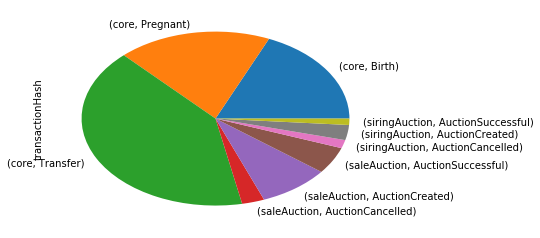

In [415]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='pie')

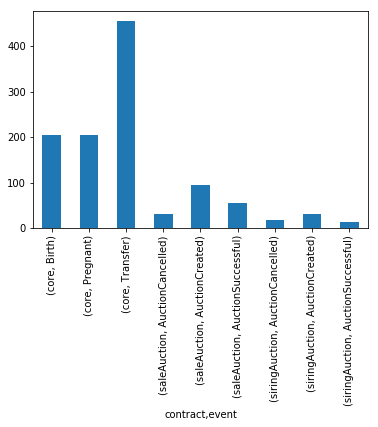

In [416]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='bar')

In [427]:
events.sort_values(['blockNumber', 'transactionIndex', 'logIndex']).head(20)

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x0000000000000000000000003c30e0ce0bd53978d8bae895e6b378e033ed129e...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0xae84ded1f4c80d73d02da4edf5950e90a002db463f57539f77834b14b94e8c78,0x13,core,Pregnant
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x00000000000000000000000017d0e82ebdef0516e196d71a1d5f1b7acadafba3...,0x5,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75,0xa,core,Birth
1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x0000000000000000000000000000000000000000000000000000000000000000...,0x6,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75,0xa,core,Transfer
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x00000000000000000000000017d0e82ebdef0516e196d71a1d5f1b7acadafba3...,0x7,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75,0xa,core,Birth
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x0000000000000000000000000000000000000000000000000000000000000000...,0x8,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75,0xa,core,Transfer
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x0000000000000000000000001bf032d01bab6cd4a2d67ec251f5c3f09728a7e3...,0x9,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75,0xa,core,Birth
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x0000000000000000000000000000000000000000000000000000000000000000...,0xa,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75,0xa,core,Transfer
6,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1fdb10081f04c9127fd4a,0x4ea2bf,0x000000000000000000000000d387a6e4e84a6c86bd90c158c6028a58cc8ac459...,0xb,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x8e27f14f3ab9e9a29127dd3078e5e5212059cabf3bfaa0a16156846bd11d69e7,0xc,core,Pregnant
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6e0713fa65b079d7a8d32,0x4ea2c0,0x00000000000000000000000089eacd3f14e387faa9f3d1f3f917ebdf8221d430...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0xfca1c4d3c4ef1337781863e74f74f6e70ca5d004d5108bed359723945c3bef80,0x1c,core,Pregnant
9,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6e0713fa65b079d7a8d32,0x4ea2c0,0x000000000000000000000000d387a6e4e84a6c86bd90c158c6028a58cc8ac459...,0x10,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0xabce181d6d671267266e5d2efc648804a4513fe15d07cfb9ac4c957733f9a7b2,0x1f,core,Pregnant


## Strange transactions: lots of births and transfers

0xdc3d978d88daa791b8e898ae74cd95a7bb5a38cab4555aac3c6da59dc09d62e0
0x58a5d848c63a0ced69c671eff4d6decb01ae57bfa8dd315ac1a758e5aa192e6e
0x5d91e6170d1cb8bf9642e4d319b87bd824b17ec52cd6b3d9a14f3f8f83e90b75

Looks like smart contracts (0xF8Fb76B05fd854cc6f35d5088B9D241CbbF616C3, 0xD18785571AE7F3b100e5B8788E3827120282f170) that call giveBirth on all pregnant kitties whose gestation period has passed

## Most wanted genes
We can get the genetic sequence of the most recent breeds to try to see what the most wanted genes are

In [420]:
pregnancies = events[events['event'] == 'Pregnant']
pregnancies.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event
6,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x000000000000000000000000d387a6e4e84a6c86bd90...,0xb,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x8e27f14f3ab9e9a29127dd3078e5e5212059cabf3bfa...,0xc,core,Pregnant
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x0000000000000000000000003c30e0ce0bd53978d8ba...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xae84ded1f4c80d73d02da4edf5950e90a002db463f57...,0x13,core,Pregnant
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x00000000000000000000000089eacd3f14e387faa9f3...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xfca1c4d3c4ef1337781863e74f74f6e70ca5d004d510...,0x1c,core,Pregnant
9,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x000000000000000000000000d387a6e4e84a6c86bd90...,0x10,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xabce181d6d671267266e5d2efc648804a4513fe15d07...,0x1f,core,Pregnant
10,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x000000000000000000000000d4aee0dd6b56bcd831ff...,0x1c,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x4a9d2e9185a9946c2be65ab4e2b139ec8bc6ede878a0...,0x37,core,Pregnant


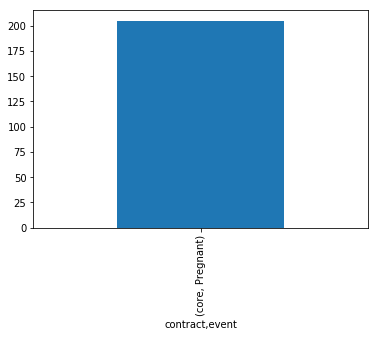

In [421]:
pregnancies.groupby(['contract','event']).transactionHash.count().plot(kind='bar')

The data field of a Pregnant should be structured as such:
1. '0x'
1. '000000000000000000000000' - 24 zeros before the owner address
1. owner address (40 hex characters)
1. matronId (64 hex characters)
1. sireId (64 hex characters)
1. cooldownEndBlock (64 hex characters)

In [423]:
pregnancies['owner'] = '0x' + pregnancies['data'].apply(lambda x: x[26:66])
pregnancies['matronId'] = pregnancies['data'].apply(lambda x: x[66:130])
pregnancies['sireId'] = pregnancies['data'].apply(lambda x: x[130:194])
pregnancies['matronId_dec'] = pregnancies['data'].apply(lambda x: int(x[66:130],16))
pregnancies['sireId_dec'] = pregnancies['data'].apply(lambda x: int(x[130:194],16))
pregnancies.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,owner,matronId,sireId,matronId_dec,sireId_dec
6,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x000000000000000000000000d387a6e4e84a6c86bd90...,0xb,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x8e27f14f3ab9e9a29127dd3078e5e5212059cabf3bfa...,0xc,core,Pregnant,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,550241,550239
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x0000000000000000000000003c30e0ce0bd53978d8ba...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xae84ded1f4c80d73d02da4edf5950e90a002db463f57...,0x13,core,Pregnant,0x3c30e0ce0bd53978d8bae895e6b378e033ed129e,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,544964,542275
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x00000000000000000000000089eacd3f14e387faa9f3...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xfca1c4d3c4ef1337781863e74f74f6e70ca5d004d510...,0x1c,core,Pregnant,0x89eacd3f14e387faa9f3d1f3f917ebdf8221d430,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,547360,547357
9,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x000000000000000000000000d387a6e4e84a6c86bd90...,0x10,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xabce181d6d671267266e5d2efc648804a4513fe15d07...,0x1f,core,Pregnant,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,546513,550238
10,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x000000000000000000000000d4aee0dd6b56bcd831ff...,0x1c,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x4a9d2e9185a9946c2be65ab4e2b139ec8bc6ede878a0...,0x37,core,Pregnant,0xd4aee0dd6b56bcd831ffb4c1d8aced71fcf37fa5,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,540869,550024


In [424]:
def getKittyGenes(kittyId):
    kitty = eth_call(to_address=coreContract, data='0xe98b7f4d'+kittyId)
    return kitty[-64:]

pregnancies['matronGenes'] = pregnancies['matronId'].apply(lambda x: '0x'+getKittyGenes(x))
pregnancies['sireGenes'] = pregnancies['sireId'].apply(lambda x: '0x'+getKittyGenes(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [425]:
pregnancies.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,owner,matronId,sireId,matronId_dec,sireId_dec,matronGenes,sireGenes
6,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x000000000000000000000000d387a6e4e84a6c86bd90...,0xb,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x8e27f14f3ab9e9a29127dd3078e5e5212059cabf3bfa...,0xc,core,Pregnant,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,550241,550239,0x00004316b398c5318c30252a630e7098933394c52823...,0x00005b108296670a5214a92939d8221a643258e30545...
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x004ce603b20da361ed0e57f771a51df66c7dee6287a1...,0x4ea2bf,0x0000000000000000000000003c30e0ce0bd53978d8ba...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xae84ded1f4c80d73d02da4edf5950e90a002db463f57...,0x13,core,Pregnant,0x3c30e0ce0bd53978d8bae895e6b378e033ed129e,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,544964,542275,0x00005ad94210e718c6e0255a630c308cc66212b38540...,0x00005ad88318c6498617201a130f1110e4639ad79480...
8,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x00000000000000000000000089eacd3f14e387faa9f3...,0xd,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xfca1c4d3c4ef1337781863e74f74f6e70ca5d004d510...,0x1c,core,Pregnant,0x89eacd3f14e387faa9f3d1f3f917ebdf8221d430,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,547360,547357,0x000042d14210a54a4211b84261ca5028016b50e03de6...,0x00005a508210e1718295ac4229580084036b14e28085...
9,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x000000000000000000000000d387a6e4e84a6c86bd90...,0x10,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0xabce181d6d671267266e5d2efc648804a4513fe15d07...,0x1f,core,Pregnant,0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,546513,550238,0x00004b16b394a54982978d4929d87090d34a0ce31084...,0x00005ad6b31ca5704c31bd2919c43218c45b5b632943...
10,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x483ccdb8dc4765a023e5d5effb428ffb90adae9210a6...,0x4ea2c0,0x000000000000000000000000d4aee0dd6b56bcd831ff...,0x1c,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff10...,0x4a9d2e9185a9946c2be65ab4e2b139ec8bc6ede878a0...,0x37,core,Pregnant,0xd4aee0dd6b56bcd831ffb4c1d8aced71fcf37fa5,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,540869,550024,0x00007a58b09c243386142c0900ce220584320c42bde3...,0x000063d8829c33718611bd6b00180610ec618c8000a3...


Next: split genes into cattributes (is that how it works?) and plot histograms